To start we'll just load our dataset of noisy images to see what they look like

In [ ]:
import pickle

noisy_images = pickle.load(open('noisy_images', 'rb')).numpy()
noisy_labels = pickle.load(open('noisy_labels', 'rb')).numpy()

print(noisy_images.shape)
print(noisy_labels.shape)

(60000, 28, 28)
(60000,)


Lets select 5 random images

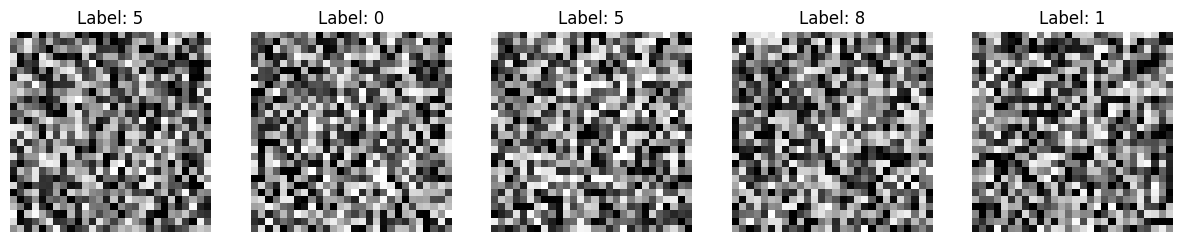

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

random_idxs = random.sample(range(len(noisy_images)), 5)
plt.figure(figsize=(15, 3))

for i, index in enumerate(random_idxs, 1):
    plt.subplot(1, 5, i)
    image = noisy_images[index]
    label = noisy_labels[index]

    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.show()

It's clear that us humans cannot classify these images but lets see if we can train a neural net to do it for us

For a start lets see what happens if we use a standard CNN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

def get_model():
    inputs = layers.Input(shape=(28, 28, 1)) # images are 28x28 (see first cell)
    x = layers.Rescaling(1.0/255.0)(inputs) # images have values in range 0-255 so we scale down for better learning
    for size in [16, 32]:
        x = layers.Conv2D(filters=size, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters=size, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters=size, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x) # prevent overfitting
    outputs = layers.Dense(10, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model

Now that we have our model lest partition the datasets and train

In [ ]:
import numpy as np

train_images = noisy_images[10000:]
train_labels = noisy_labels[10000:]

validation_images = noisy_images[5000:10000]
validation_labels = noisy_labels[5000:10000]

callbacks = [
  keras.callbacks.ModelCheckpoint("../Models/CNN_Model.h5", save_best_only=True, monitor="val_loss"),
  keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

model = get_model()

model.fit(train_images, train_labels,
batch_size=256,
epochs=50,
validation_data=(validation_images, validation_labels),
callbacks=callbacks)

Epoch 1/50
196/196 [==============================] - 7s 14ms/step - loss: 2.3017 - accuracy: 0.1094 - val_loss: 2.2999 - val_accuracy: 0.1086
Epoch 2/50
 11/196 [>.............................] - ETA: 2s - loss: 2.2990 - accuracy: 0.1222

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 2s 13ms/step - loss: 2.1895 - accuracy: 0.1933 - val_loss: 2.0113 - val_accuracy: 0.2826
Epoch 3/50
196/196 [==============================] - 3s 14ms/step - loss: 2.0054 - accuracy: 0.2899 - val_loss: 1.8845 - val_accuracy: 0.3448
Epoch 4/50
196/196 [==============================] - 3s 15ms/step - loss: 1.8121 - accuracy: 0.3684 - val_loss: 1.6033 - val_accuracy: 0.4380
Epoch 5/50
196/196 [==============================] - 3s 13ms/step - loss: 1.5782 - accuracy: 0.4560 - val_loss: 1.5455 - val_accuracy: 0.5024
Epoch 6/50
196/196 [==============================] - 3s 13ms/step - loss: 1.4515 - accuracy: 0.5023 - val_loss: 1.3225 - val_accuracy: 0.5398
Epoch 7/50
196/196 [==============================] - 3s 13ms/step - loss: 1.3679 - accuracy: 0.5333 - val_loss: 1.2662 - val_accuracy: 0.5666
Epoch 8/50
196/196 [==============================] - 3s 13ms/step - loss: 1.3161 - accuracy: 0.5532 - val_loss: 1.2967 - val_accuracy: 0.5682
Epoch 9/50

Now lets test our model on the test dataset

In [ ]:
from tensorflow.keras.models import load_model

test_images = noisy_images[:5000]
test_labels = noisy_labels[:5000]

model = load_model('../Models/CNN_Model.h5')

results = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {results[1]}")

157/157 [==============================] - 1s 4ms/step - loss: 1.0392 - accuracy: 0.6472
Test Accuracy: 0.6471999883651733


So our baseline is 64%, lets see if we can improve this.